<a href="https://colab.research.google.com/github/SaranAI/thaichar2vec/blob/main/notebooks/research/train_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook
- This notebook implemented skip-gram and cbow model on thai corpus to obtain thai embedding
- Although most cases are better ะน use (sub)word over character embedding, however, it might be useful for some cases like
1. name generation
2. thai word cut

## Goal
- To maximize the entropy of the work in corpus

## Method
- Obtain Corpora
  - name-surname corpus
  - thai vocabulary ฉบับราชบั
- Train
  - skipgram
  - cbow
- Visualize

In [1]:
# Import Data
%%capture

# Name-surname corpus
!wget -O male_name.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/male_names_th.txt
!wget -O female_name.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/female_names_th.txt
!wget -O surname.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/surnames_th.txt

# Thai Lexicon Vocabulary
!wget -O lexicon.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/lexicon_th.txt

In [2]:
from typing import List, Set, Union, Dict, Tuple
import os

# Define functions
def open_txt(txt_file:str)->List:
  """
  Read lines from txt file and return a list where
  each list element represent each line
  """
  output_list = []
  with open(txt_file,"r") as f:
    lines = f.readlines()
    for line in lines:
     output_list.append(line.strip())
  return output_list

def get_corpora(corpus_file_names:List[str],
                root_dir:str="/content",
                verbose=True)->Set[str]:

  """
  Import all corpus files

  Output:
    - set of all words (set)
  """

  corpus_list = []
  for corpus_file_name in corpus_file_names:
    corpus = open_txt(os.path.join(root_dir,corpus_file_name))
    print(f"len({corpus_file_name})={len(corpus)}") if verbose else None
    corpus_list.append(corpus)

  corpora = set()
  for corpus in corpus_list:
    corpora.update(corpus)

  print(f"{len(corpora)=}") if verbose else None
  return corpora

In [3]:
corpus_file_name = ["male_name.txt",
                    "female_name.txt",
                    "surname.txt",
                    "lexicon.txt"]

corpora = get_corpora(corpus_file_name,verbose=True)

len(male_name.txt)=7124
len(female_name.txt)=5098
len(surname.txt)=9836
len(lexicon.txt)=37675
len(corpora)=56983


- We found some of vocabulary word contain no thai character, so we will remove the word contain that out,

In [4]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 64.2 MB/s eta 0:00:00


In [5]:
WHITELIST = list("กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮฤฦะัาำิีึืุูเแโใไๅํ็่้๊๋ฯฺๆ์ํ")
# Pop duplicated
WHITELIST = sorted(list(set(WHITELIST)))

def preprocess(corpus:Set[str],
               whitelist:Union[List,str]=WHITELIST,
               verbose:bool=True)->Set[str]:
  """
  Perform preprocessing to the vocabulary inside corpus

  Note:
    This function mutates the corpus in-place
  """
  # REF:Obtain and partially remove some from Pythainlp.thai_characters

  for word in corpus.copy():
    # Inspect in character level
    for char in word:
      if char not in whitelist:
        corpus.remove(word)
        print(f'Remove word "{word}" containing "{char}"') if verbose else None
        break

  print(f"{len(corpus)=}" if verbose else None)
  return corpus

In [6]:
tone = ["่","้","๊","๋"]
syllable = list("ะัาำิีึืุูเแโใไๅํ็่้๊๋ฯฺๆ์ํ")

In [7]:
consonants = [
    "ก", "ข", "ฃ", "ค", "ฅ", "ฆ", "ง", "จ", "ฉ", "ช", "ซ", "ฌ", "ญ", "ฎ", "ฏ",
    "ฐ", "ฑ", "ฒ", "ณ", "ด", "ต", "ถ", "ท", "ธ", "น", "บ", "ป", "ผ", "ฝ", "พ",
    "ฟ", "ภ", "ม", "ย", "ร", "ล", "ว", "ศ", "ษ", "ส", "ห", "ฬ", "อ", "ฮ"
]

vowels = [
    "ะ", "ั", "า", "ำ", "ิ", "ี", "ึ", "ื", "ุ", "ู","เ","แ","โ","ใ","ไ"
]

tone_markers = [
    "่", "้", "๊", "็"
]

other_characters = [
    "์", "ํ", "ๆ", "ฯ", "ฺ"
]


In [8]:
len(consonants + vowels + tone_markers + other_characters)

68

In [9]:
len(list(WHITELIST))

72

In [10]:
corpora = preprocess(corpora, WHITELIST)

Remove word "อติชาต-" containing "-"
Remove word "หลัว ๆ" containing " "
Remove word "สัปปุริส-" containing "-"
Remove word "หมดเนื้อ หมดตัว" containing " "
Remove word "ชักน้ำเข้าลึก ชักศึกเข้าบ้าน" containing " "
Remove word "รู้หลบเป็นปีก รู้หลีกเป็นหาง" containing " "
Remove word "ย็อกแย็ก ๆ" containing " "
Remove word "ทิน-" containing "-"
Remove word "ชงฆ-" containing "-"
Remove word "เหย่า ๆ" containing " "
Remove word "ไทย-" containing "-"
Remove word "ควิว ๆ" containing " "
Remove word "ริก ๆ" containing " "
Remove word "ดุ่ม ๆ" containing " "
Remove word "กระแด่ว ๆ" containing " "
Remove word "ปฏิภาค-" containing "-"
Remove word "ไพรัช-" containing "-"
Remove word "กรร-" containing "-"
Remove word "โหย่ง ๆ" containing " "
Remove word "มิคสิร-" containing "-"
Remove word "หัตถ-" containing "-"
Remove word "อัทธ-" containing "-"
Remove word "ภว-" containing "-"
Remove word "อนีก-" containing "-"
Remove word "อุปัชฌาย-" containing "-"
Remove word "ฮือ ๆ" containing " "
Remove wo

- Make sure that the all characters from whitelist was contained in this corpus

In [11]:
def check_diff_charset(corpus:Set[str],
                       whitelist:Union[List[str],str])->Set[str]:
  """
    Check and return the difference in character sets between a corpus of words and a whitelist.

    Args:
        corpus (Set[str]): A set of words to examine for character set differences.
        whitelist (Union[List[str], str]): A whitelist of characters (either a list of characters or a string).

    Returns:
        Set[str]: A set of characters present in the whitelist but not in the corpus.
    """
  whitelist_charset = set(whitelist)
  corpus_charset = set()
  for word in corpus:
    # Inspect in character level
    for char in word:
      corpus_charset.add(char)

  diff_charset = whitelist_charset.difference(corpus_charset)
  return diff_charset


In [12]:
diff_charset = check_diff_charset(corpora,WHITELIST)

# Since our corpus does not contain
# Get Corpus Char list
CHARLIST = WHITELIST.copy()
for diff_char in diff_charset:
  CHARLIST.remove(diff_char)

In [13]:
len(CHARLIST)

69

In [14]:
# Initiate some type hint
from typing import TypedDict
from collections import OrderedDict

def make_vocabulary(charlist:List[str],
                    add_special_token:bool=True)->Dict[str,int]:
  """
  Make vocabulary where a key represent character token and a value represent id token from character list

  Args:
  1. charlist
    A list of character token derived from the corpus
  2. add_special_token :
    adding the special tokn which does not derived from input containing <PADDING>

  Example:
    vocabulary = {"ก" : 0,
                  "ข" : 1,
                  "ค" : 2}
  """
  vocabulary = OrderedDict()

  # Add Special Token
  if add_special_token:
    special_token_list = ["<pad>","<unk>"]
    for i,char in enumerate(special_token_list):
      vocabulary.update({char : i})

  # Add char from charlist
  start_idx = len(vocabulary)
  for i,char in enumerate(charlist,start_idx):
    vocabulary.update({char : i})

  return vocabulary

In [15]:
vocabulary = make_vocabulary(CHARLIST)
reverse_vocabulary = {v: k for k, v in vocabulary.items()}
print(f"{len(vocabulary)=}")
# vocab

len(vocabulary)=71


In [16]:
# Let check total characters
from functools import reduce
total_char_sum = reduce(lambda x, y: x + len(y), corpora, 0)
print(f"Total characters in corpus : {total_char_sum}")

Total characters in corpus : 416715


## Make Dataset for each architecture
- Word2vec Skipgram
- Word2vec CBOW



### 1. Word2vec ▶



#### Make DataFrame

In [17]:
import pandas as pd

# Now we make a function which turn corpus into datas
def make_word2vec_dataset(corpus:str,
                          window_size:int=2,
                          method="skipgram",
                          add_pad_token:bool=True)->pd.DataFrame:

  if method not in ["skipgram","cbow"]:
    raise NotImplementedError(f"Make sure method is skipgram or cbow")

  dataset = []
  for word in corpus:
    rows = word_to_skipgram_row(word,window_size,add_pad_token)
    dataset.extend(rows)

  # Convert tuple to pandas
  dataset = pd.DataFrame(dataset, columns=['target','context'])

  if method=="cbow":
    # We swap column if
    dataset = dataset.reindex(columns=["context","target"])

  return dataset

def word_to_skipgram_row(word:str,
                         window_size:int=2,
                         add_pad_token:bool=True)->List[tuple]:
  """
    add_pad_token [bool] : add padding token
  """
  rows = []

  for idx in range(len(word)):
    # assign the current char
    char = word[idx]

    # Get prior index
    prev_idx = idx - window_size
    next_idx = idx + window_size
    # Create new instance where context as previous
    for i in range(prev_idx,idx):
      # Context as pad if out of border
      if i < 0:
        if add_pad_token:
          row = (char,"<pad>")
        else:
          # Skip if not add_pad_token
          continue
      else:
        row = (char,word[i])
      rows.append(row)

    # Create new instance where context as next
    for i in range(idx+1,next_idx+1):
      # Create new instance
      if i > len(word)-1:
        if add_pad_token:
          row = (char,"<pad>")
        else:
          # Skip if not add_pad_token
          continue
      else:
        row = (char,word[i])
      rows.append(row)

  return rows

def token_to_id_dataset(dataset:pd.DataFrame,
                        vocabulary:Dict[str,int])->pd.DataFrame:
  """
    Map tokens in the 'target' and 'context' columns of the DataFrame to their integer IDs based on the provided vocabulary.

    Args:
    - dataset (pd.DataFrame): The input DataFrame with 'target' and 'context' columns containing tokens to be mapped.
    - vocabulary (Dict[str, int]): A dictionary that maps tokens (str) to their corresponding integer IDs (int).

    Returns:
    - pd.DataFrame: The modified DataFrame with 'target' and 'context' columns replaced by integer IDs.
  """
  dataset['target'] = dataset['target'].map(vocabulary)
  dataset['context'] = dataset['context'].map(vocabulary)
  return dataset

In [18]:
cbow_df = make_word2vec_dataset(corpora,
                                window_size=2,
                                method="cbow",
                                add_pad_token=False)

skipgram_df = make_word2vec_dataset(corpora,
                                     window_size=2,
                                     method="skipgram",
                                     add_pad_token=False)
print("CBOW Dataset :")
display(cbow_df)

print("Skipgram Dataset :")
display(skipgram_df)

CBOW Dataset :


,context,target
0,ู,ภ
1,น,ภ
2,ภ,ู
3,น,ู
4,ว,ู
...,...,...
1334217,ต,า
1334218,่,า
1334219,ย,า
1334220,่,ย


Skipgram Dataset :


,target,context
0,ภ,ู
1,ภ,น
2,ู,ภ
3,ู,น
4,ู,ว
...,...,...
1334217,า,ต
1334218,า,่
1334219,า,ย
1334220,ย,่


In [19]:
# Convert them to integer
cbow_df = token_to_id_dataset(cbow_df,vocabulary)
skipgram_df = token_to_id_dataset(skipgram_df,vocabulary)

In [20]:
cbow_df

,context,target
0,57,33
1,26,33
2,33,57
3,26,57
4,40,57
...,...,...
1334217,22,50
1334218,65,50
1334219,35,50
1334220,65,35


#### Make Torch Dataset & Loader

In [21]:
# Define a custom dataset
from torch.utils.data import DataLoader, Dataset
class Word2VecDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [22]:
# Create Dataset for both Skipgram and CBOW
## Notice, The data for skipgram and cbow is just a swap
skipgram_dataset = Word2VecDataset(data=cbow_df["target"],
                                   labels=cbow_df["context"],
                                   transform=None)

cbow_dataset = Word2VecDataset(data=skipgram_df["context"],
                              labels=skipgram_df["target"],
                              transform=None)

In [23]:
batch_size = 128
skipgram_loader = DataLoader(skipgram_dataset, batch_size, shuffle=True)
cbow_loader = DataLoader(cbow_dataset, batch_size, shuffle=True)

In [24]:
# To easily instantiate dataloader by setting, use later on hyperparameter fine tuning
def make_word2vec_dataloader(corpora,
                             vocabulary,
                             window_size=2,
                             method="cbow",
                             add_pad_token:bool=False,
                             batch_size:int=16
                             )->DataLoader:

  # Define X,y
  x,y = (("context","target") if method=="cbow"
         else ("target","context"))

  # Make Pandas dataframe
  df = make_word2vec_dataset(corpora,
                             window_size,
                             method,
                             add_pad_token)
  df = token_to_id_dataset(df,vocabulary)

  # Make Pytorch Dataset
  dataset = Word2VecDataset(data=df[x],
                            labels=df[y],
                            transform=None)

  loader = DataLoader(dataset, batch_size, shuffle=True)
  return loader

#### Make Architecture

- Since our dataset split into a pair of context and target individually
  - Instead of (1 -> (0,3))
    We split into (1,0), (1,3)
  - So, the architecture for both method `skipgram` and `cbow` are the same

  ![skipgram](https://www.researchgate.net/publication/322905432/figure/fig1/AS:614314310373461@1523475353979/The-architecture-of-Skip-gram-model-20.png)

  - We treat each pair of target and different context as different instance
  - Hence, let's called word2vec architecture

In [25]:
# Define a simple neural network model
import torch.nn as nn
import torch.nn.functional as F
import torch

class Word2VecModel(nn.Module):
    def __init__(self,vocab_size,emb_size):
      super(Word2VecModel, self).__init__()
      # Typically, emb_size is lower than vocab_size
      self.embedding = nn.Embedding(vocab_size, emb_size)
      self.fc1 = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        return x

- ⚠ Note : embedding layer take input token as input not the one hot encoding unlike linear layer
- This is why our dataset does not convert id token into one hot

In [26]:
def test_forward_word2vec():
  # Generate two one-hot vector : One hot for class 2 and 10 with size 71
  vocab_size = 71
  emb_size = 15
  class_indices = [2,10]
  input_vector = torch.tensor([0,3]) # (<pad>,ข)
  # Initiate model
  word2vec = Word2VecModel(vocab_size,emb_size)
  # Test Forward
  print(f"{input_vector.shape=}")
  out = word2vec(input_vector)
  return out

out = test_forward_word2vec()
out.shape

input_vector.shape=torch.Size([2])


torch.Size([2, 71])

#### Make Trainer
- Use to be a medium for data and architecture

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [28]:
import numpy as np

# Our metric
def calculate_perplexity_from_ce_loss(loss:float)->float:
  perplexity  = np.exp(loss)
  return perplexity

In [29]:
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime
import os
import csv

def train_step(model, inputs, labels, criterion, optimizer, device):
  optimizer.zero_grad()
  inputs = inputs.to(device)  # Move inputs to GPU
  labels = labels.to(device)  # Move labels to GPU
  # Forward
  outputs = model(inputs)  # shape:(bs x vocab_size)
  # Backward
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

  return loss.item()

def train_epoch(model, train_loader, criterion, optimizer, device):
  total_loss = 0.0
  loop = tqdm(train_loader,desc="Training")

  for i,(inputs, labels) in enumerate(loop):
    loss = train_step(model, inputs, labels, criterion, optimizer, device)
    total_loss += loss
    loop.set_postfix(loss=loss)
  return total_loss

def train(model,
          train_loader,
          criterion,
          optimizer,
          model_path:str,
          num_epochs=5,
          device='cuda'):
  """

  Arg:
    model_path - the destination path that store best model as best.pt and final model as final.pt
  """

  # Initiate tracker
  best_loss = np.inf
  histories = []
  model.to(device)
  for epoch in range(num_epochs):
    total_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    mean_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {mean_loss}")
    perplexity = calculate_perplexity_from_ce_loss(mean_loss)
    # Save best model
    if best_loss > mean_loss:
      best_loss = mean_loss
      print(f"Best model saved at epoch {epoch + 1}")

      # Define the header for the CSV file
      torch.save(model.state_dict(), os.path.join(model_path,'best.pth'))

      # Append history of epoch
      history = [epoch,mean_loss,perplexity]
      histories.append(history)

  # Save Final model
  print(f"Final model saved at epoch {epoch + 1}")
  torch.save(model.state_dict(), os.path.join(model_path,'final.pth'))
  final_loss = mean_loss

  # Write and submit histories
  header = ["epoch","loss","perplexity"]
  with open(f'train_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    for history in histories:
        writer.writerow(history)

  return model, best_loss, final_loss

#### Start training CBOW

In [30]:
# Mount to store model in here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M:%S")

In [32]:
import os
import json
from datetime import datetime

# Initiate meta
vocab_size = len(vocabulary)
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_path = f'/content/drive/MyDrive/thaichar2vec/cbow/{now}'
if not os.path.exists(model_path): os.makedirs(model_path) # Make directory if not exist

# Define Hyperparameter
method="cbow"
add_pad_token = False
batch_size = 512
emb_size = 32
num_epochs = 5000
learning_rate = 1e-3
window_size = 1

# Create Dataloader
cbow_loader = make_word2vec_dataloader(corpora,
                                       vocabulary,
                                       window_size,
                                       method,
                                       add_pad_token,
                                       batch_size)

# Define LOAD
model = Word2VecModel(vocab_size,emb_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

"""Unfrozen to train

# Write model metadata
with open(os.path.join(model_path,"hyperparameter.json"),"w") as f:
  dictionary = dict(method=method,
                    add_pad_token=add_pad_token,
                    batch_size=batch_size,
                    emb_size=emb_size,
                    num_epochs=num_epochs,
                    learning_rate=learning_rate,
                    window_size=window_size)

  json_object = json.dumps(dictionary, indent=4)
  f.write(json_object)

# Start training CBOW
model, best_loss, final_loss = train(model,
                                    cbow_loader,
                                    criterion,
                                    optimizer,
                                    model_path,
                                    num_epochs)

# Submit Result
with open(os.path.join(model_path,"result.json"),"w") as f:
  dictionary = dict(best_loss=best_loss,
                    final_loss=final_loss)

  json_object = json.dumps(dictionary, indent=4)
  f.write(json_object)
"""

'Unfrozen to train\n\n# Write model metadata\nwith open(os.path.join(model_path,"hyperparameter.json"),"w") as f:\n  dictionary = dict(method=method,\n                    add_pad_token=add_pad_token,\n                    batch_size=batch_size,\n                    emb_size=emb_size,\n                    num_epochs=num_epochs,\n                    learning_rate=learning_rate,\n                    window_size=window_size)\n\n  json_object = json.dumps(dictionary, indent=4)\n  f.write(json_object)\n\n# Start training CBOW\nmodel, best_loss, final_loss = train(model,\n                                    cbow_loader,\n                                    criterion,\n                                    optimizer,\n                                    model_path,\n                                    num_epochs)\n\n# Submit Result\nwith open(os.path.join(model_path,"result.json"),"w") as f:\n  dictionary = dict(best_loss=best_loss,\n                    final_loss=final_loss)\n\n  json_object = j

### Obtain best cbow model based on epoch

In [37]:
# Load Best model
import os
best_model_directory = "/content/drive/MyDrive/thaichar2vec/cbow/2023-10-02 15_19_32"
best_model_path = os.path.join(best_model_directory,"best.pth")
best_model_history = os.path.join(best_model_directory,"train_history.csv")

In [38]:
model = Word2VecModel(vocab_size,emb_size)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

[Text(0.5, 1.0, 'Perplexity over epoch')]

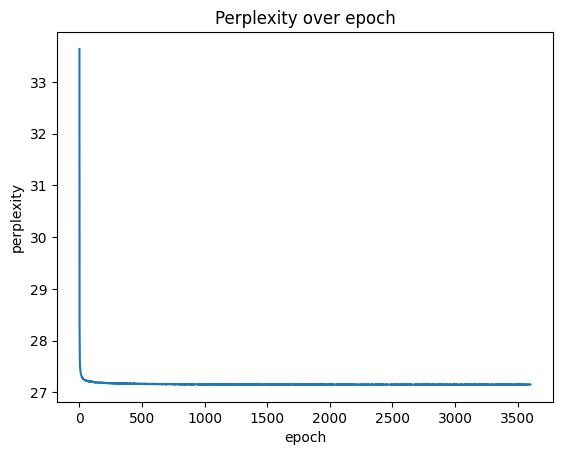

In [56]:
import seaborn as sns
history = pd.read_csv(best_model_history)
plot = sns.lineplot(x="epoch",y="perplexity",data=history,)
plot.set(title='Perplexity over epoch')

In [57]:
import numpy as np
from scipy.spatial import distance

emb_matrix = model.embedding.weight.data.cpu().numpy()
print(f"{emb_matrix.shape = }")

def check_similarity(char:str,
                     vocabulary:Dict[int,str],
                     top_k:int=5,
                     metric="euclidean",
                     emb_matrix=emb_matrix):

  # Initiate reverse vocabulary
  reverse_vocabulary = {v: k for k, v in vocabulary.items()}

  char_id = vocabulary[char]
  # GEt row vector of particular char_id
  char_vector = emb_matrix[[char_id],:]

  # Calculate the pairwise Euclidean distances
  distances = distance.cdist(emb_matrix,
                             char_vector,
                             metric="euclidean")

  # Get the row indices sorted by minima
  sorted_indices = np.argsort(distances.flatten())
  sorted_distance = np.sort(distances.flatten())

  # The top_k rows with the smallest minima
  top_k_indices = sorted_indices[:top_k+1]
  top_k_distances = sorted_distance[:top_k+1]

  result = dict()
  for index,dist in zip(top_k_indices,top_k_distances):
    char_word = reverse_vocabulary[index]
    result.update({char_word : dist})
  return result

print(check_similarity("ิ",vocabulary,10))
print(check_similarity("ก",vocabulary,10))
print(check_similarity("เ",vocabulary,10))
print(check_similarity("ส",vocabulary,10))

emb_matrix.shape = (71, 32)
{'ิ': 0.0, 'ุ': 2.2208638602414412, 'ู': 2.779785165427632, 'ั': 2.96636914739089, 'ี': 2.9819424243743025, 'า': 3.033806561493627, 'น': 3.7398887857187897, 'ม': 3.755037163882374, 'ย': 3.7635993880229126, 'ก': 3.7672896329492795, 'เ': 3.7760456565054166}
{'ก': 0.0, 'บ': 1.582567330641343, 'ม': 1.7617345193160445, 'ป': 1.81611430415044, 'ด': 1.9373294373600745, 'ส': 2.13404747272756, 'ย': 2.188925858959489, 'ว': 2.256159838509214, 'น': 2.2562326627077662, 'ต': 2.2794255277589914, 'พ': 2.3305616024831246}
{'เ': 0.0, 'โ': 1.540012806560709, 'แ': 2.3690510453581286, 'ไ': 2.5687998053992844, 'ร': 2.955098221999607, 'ก': 2.987771830470337, 'ม': 3.01694600681668, 'ด': 3.0835427774153503, 'ย': 3.0931121190672726, 'ว': 3.1508010879622907, 'บ': 3.1844787997015698}
{'ส': 0.0, 'บ': 2.074161156429052, 'ก': 2.13404747272756, 'ม': 2.180769835174647, 'ย': 2.2063346488638995, 'ด': 2.215124956184611, 'อ': 2.2245708152344683, 'ป': 2.3096237848827226, 'ต': 2.3291910748304123, 

In [58]:
emb_matrix

array([[-1.3391574e-01, -1.9358985e+00,  3.7479240e-01, ...,
         9.9274355e-01, -1.6441355e+00,  1.1813228e+00],
       [ 1.5243670e-01, -2.1362245e+00, -7.0710599e-01, ...,
        -3.8612941e-01, -1.3003817e+00,  1.6502310e+00],
       [-2.0282443e-01, -1.1987339e-01, -4.3932033e-01, ...,
         1.3721201e-01,  8.0120020e-02,  3.1007510e-01],
       ...,
       [ 1.6588464e+00,  3.7007239e-02,  2.2468224e+00, ...,
         4.0705032e+00,  1.3147724e+00,  6.2733436e-01],
       [-5.6879502e-03, -1.6778739e-01,  6.3496232e-01, ...,
        -1.7610985e-01,  1.1132747e-01, -1.4969746e+00],
       [ 5.9969444e+00, -4.2448745e+00, -2.7517197e+00, ...,
        -2.2827342e+00,  7.3495450e+00, -1.5733734e+01]], dtype=float32)

### Visualize embedding vector in low dimensional space

In [59]:
# Setup Thai font first
import matplotlib as mpl
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont("/content/thsarabunnew-webfont.ttf")
mpl.rc("font",family="TH Sarabun New", size=20)

In [60]:
thai_category_char = {
    "consonants" : list("กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ"),
    "tonemarks" : list("่้๊๋"),
    "vowels" : list("ฤฦะัาำิีึืุูเแโใไๅํ็"),
    "others" : list("์")
}

def categorize_char(char):
    if char in thai_category_char["consonants"]:
        return 'Consonant'
    elif char in thai_category_char["tonemarks"]:
        return 'Tonemark'
    elif char in thai_category_char["vowels"]:
        return 'Vowel'
    elif char in thai_category_char["others"]:
        return 'Other'
    else:
        return 'Unknown'

In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_from_embed_matrix(emb_matrix,
                                blacklist_chars:List=['<unk>', '<pad>'],
                                perplexity=5,
                                model_name="CBOW window size : 1"):
  # Crate tsne embed matrix
  tsne_embedded = TSNE(n_components=2,
                  learning_rate='auto',
                  init='pca',
                  n_iter=100000000,
                  perplexity=perplexity).fit_transform(emb_matrix)

  # Format tsne matrix to dataframe
  tsne_data = {
    'x': tsne_embedded[:, 0],
    'y': tsne_embedded[:, 1],
    'label': [reverse_vocabulary[i] for i in range(len(tsne_embedded))],
  }

  tsne_df = pd.DataFrame(tsne_data)
  tsne_df['category'] = tsne_df['label'].apply(categorize_char)

  # Drop row with blacklist char
  print(tsne_df)
  tsne_df = tsne_df[~tsne_df['label'].isin(blacklist_chars)].reset_index(drop=True)
  # Plot
  ax = sns.scatterplot(x='x', y='y', hue='category', data=tsne_df, palette='tab10')

  # Annotate the points with labels
  plt.title(f"T-SNE of {model_name} with perplexity: {perplexity}")
  for line in range(0, tsne_df.shape[0]):
      plt.text(tsne_df.x[line], tsne_df.y[line], tsne_df.label[line],
               horizontalalignment='left', fontsize=9, color='black')

  # Move the legend outside of the plot
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()




            x          y  label   category
0    8.081872  -1.824891  <pad>    Unknown
1   -1.584655 -11.400424  <unk>    Unknown
2   -0.608268  -2.146809      ก  Consonant
3    3.188412  -6.417852      ข  Consonant
4  -11.700601  -0.383987      ฃ  Consonant
..        ...        ...    ...        ...
66   4.660373   7.943783      ้   Tonemark
67  -0.600202   6.597728      ๊   Tonemark
68   1.157601   9.086990      ๋   Tonemark
69  -6.892349  -1.396420      ์      Other
70 -10.236281  -8.393350      ํ      Vowel

[71 rows x 4 columns]


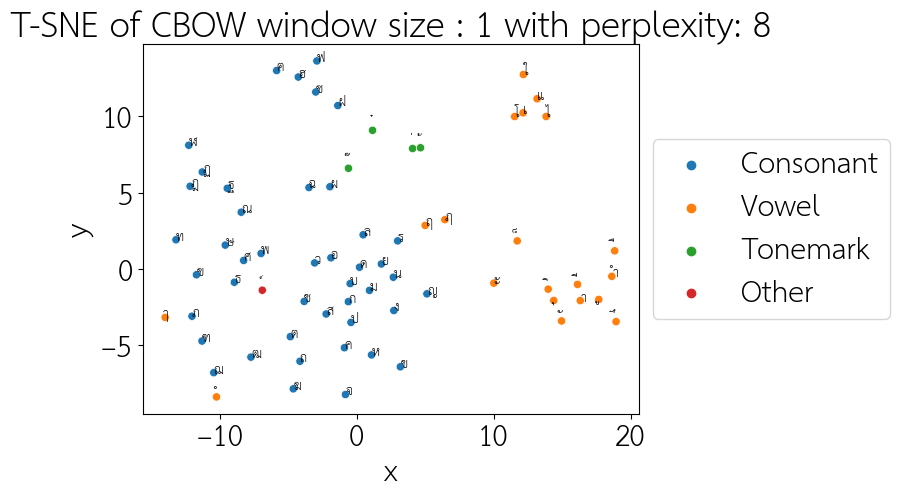

In [88]:
plot_tsne_from_embed_matrix(emb_matrix,
                            perplexity=8
                            )

In [87]:
import json
# Lastly, we ignore
# Save emb matrix as numpy array (.npz)
print(f"{emb_matrix.shape = }")
np.savez("cbow_emb_matrix.npz",emb_matrix)

with open("vocabulary.json","w",encoding="utf-8") as f:
  json.dump(vocabulary,f,ensure_ascii=False)

emb_matrix.shape = (71, 32)
